In [1]:
import os
import shutil
import glob
import torch
from torchinfo import summary
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image
import cv2

import random
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score
from sklearn.metrics import confusion_matrix, roc_curve, auc
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.manifold import TSNE

In [2]:
os.chdir(r"/mnt/hd1/ani/HIPT/HIPT_4K")
from hipt_4k import HIPT_4K
from hipt_model_utils import get_vit256, get_vit4k, eval_transforms
from hipt_heatmap_utils import *
from attention_visualization_utils import *
light_jet = cmap_map(lambda x: x/2 + 0.5, matplotlib.cm.jet)

In [3]:
# Device + Hyperparameters
device = "cuda" if torch.cuda.is_available() else "cpu"
print(device)

# Check GPU properties
for i in range(torch.cuda.device_count()): 
    print(torch.cuda.get_device_properties(i))
    
    # Get memory
    print('Total memory in GB: ', torch.cuda.get_device_properties(i).total_memory/(1.024*1e9))
    print('Memory reserved in GB: ', torch.cuda.memory_reserved(i)/(1.024*1e9))
    print('Memory allocated in GB: ', torch.cuda.memory_allocated(i)/(1.024*1e9))

cuda
_CudaDeviceProperties(name='NVIDIA RTX A5000', major=8, minor=6, total_memory=24251MB, multi_processor_count=64)
Total memory in GB:  24.83328
Memory reserved in GB:  0.0
Memory allocated in GB:  0.0


In [4]:
pretrained_weights256 = '../Checkpoints/vit256_small_dino.pth'
pretrained_weights4k = '../Checkpoints/vit4k_xs_dino.pth'
device256 = torch.device('cpu')
device4k = torch.device('cpu')

### ViT_256 + ViT_4K loaded independently (used for Attention Heatmaps)
model256 = get_vit256(pretrained_weights=pretrained_weights256, device=device256)
model4k = get_vit4k(pretrained_weights=pretrained_weights4k, device=device4k)

### ViT_256 + ViT_4K loaded into HIPT_4K API
model = HIPT_4K(pretrained_weights256, pretrained_weights4k, device256, device4k)
model.eval()

# Print model summary
summary(model=model,
        col_width=12,
        row_settings=["var_names"]
       )

Take key teacher in provided checkpoint dict
Pretrained weights found at ./Checkpoints/vit256_small_dino.pth and loaded with msg: _IncompatibleKeys(missing_keys=[], unexpected_keys=['head.mlp.0.weight', 'head.mlp.0.bias', 'head.mlp.2.weight', 'head.mlp.2.bias', 'head.mlp.4.weight', 'head.mlp.4.bias', 'head.last_layer.weight_g', 'head.last_layer.weight_v'])
# of Patches: 196
Take key teacher in provided checkpoint dict
Pretrained weights found at ./Checkpoints/vit4k_xs_dino.pth and loaded with msg: _IncompatibleKeys(missing_keys=[], unexpected_keys=['head.mlp.0.weight', 'head.mlp.0.bias', 'head.mlp.2.weight', 'head.mlp.2.bias', 'head.mlp.4.weight', 'head.mlp.4.bias', 'head.last_layer.weight_g', 'head.last_layer.weight_v'])
Take key teacher in provided checkpoint dict
Pretrained weights found at ./Checkpoints/vit256_small_dino.pth and loaded with msg: _IncompatibleKeys(missing_keys=[], unexpected_keys=['head.mlp.0.weight', 'head.mlp.0.bias', 'head.mlp.2.weight', 'head.mlp.2.bias', 'head.

Layer (type (var_name))                       Param #
HIPT_4K (HIPT_4K)                             --
├─VisionTransformer (model256)                76,032
│    └─PatchEmbed (patch_embed)               --
│    │    └─Conv2d (proj)                     (295,296)
│    └─Dropout (pos_drop)                     --
│    └─ModuleList (blocks)                    --
│    │    └─Block (0)                         (1,774,464)
│    │    └─Block (1)                         (1,774,464)
│    │    └─Block (2)                         (1,774,464)
│    │    └─Block (3)                         (1,774,464)
│    │    └─Block (4)                         (1,774,464)
│    │    └─Block (5)                         (1,774,464)
│    │    └─Block (6)                         (1,774,464)
│    │    └─Block (7)                         (1,774,464)
│    │    └─Block (8)                         (1,774,464)
│    │    └─Block (9)                         (1,774,464)
│    │    └─Block (10)                        (1,774,464)
│  

## Standalone HIPT_4K Model Inference

In [5]:
region = Image.open('/mnt/hd1/ani/Liver_pathology_project/Prepared_datasets/Tile_size_4096x4096/Testing_sd_30/Test_set_NASH_id_105_ACR_id_504/NASH/105_14_4.png')
region = region.convert('RGB')   # converting MxNx4 (RGBA) --> MxNx3 (RGB format)

x = eval_transforms()(region).unsqueeze(dim=0)
print('Input Shape:', x.shape)
print('Output Shape:', model.forward(x).shape)

Input Shape: torch.Size([1, 3, 4096, 4096])
Output Shape: torch.Size([1, 192])


## HIPT_4K Attention Heatmaps

##### Code for producing attention results (for [256 x 256], [4096 x 4096], and hierarchical [4096 x 4096]) can be run (as-is) below. There are several ways these results can be run:

hipt_4k.py Class (Preferred): This class blends inference and heatmap creation in a seamless and more object-oriented manner, and is where I am focusing my future code development around.
Helper Functions in hipt_heatmap_utils.py (Soon-to-be-deprecated): Heatmap creation was originally written as helper functions. May be more useful and easier from research perspective.
Please use whatever is most helpful for your use case :)

## 256 x 256 Demo (Saving Attention Maps Individually)

In [6]:
# ### Lets automate this to save Attention maps of a bunch of images we wish to analyze
# path_test_imgs = '/mnt/hd1/ani/Liver_pathology_project/Prepared_datasets/Tile_size_256x256/Testing_sd_30/Test_set_NASH_id_156_ACR_id_262/NASH/'
# output_dir_parent = '/mnt/hd1/ani/Liver_pathology_project/Results/HIPT/4096x4096 images/Test_set_NASH_id_156/256_individual/'

# test_imgs_list = (glob.glob(path_test_imgs + "*.png"))
# # len(test_imgs_list)

# for i in range(len(test_imgs_list)):
#     patch = Image.open(test_imgs_list[i])
#     patch = patch.convert('RGB')   # converting MxNx4 (RGBA) --> MxNx3 (RGB format)
#     output_dir = output_dir_parent + str(i+1)
#     os.makedirs(output_dir, exist_ok=True)
#     create_patch_heatmaps_indiv(patch, model256, 
#                                    output_dir, fname=('patch'+str(i+1)), 
#                                    cmap=plt.get_cmap('coolwarm'), device256=torch.device("cuda")
#                                    )
#     del patch

## 256 x 256 Demo (Concatenating + Saving Attention Maps)

In [7]:
# ### Lets automate this to save Attention maps of a bunch of images we wish to analyze
# path_test_imgs = '/mnt/hd1/ani/Liver_pathology_project/Prepared_datasets/Tile_size_256x256/Testing_sd_30/Test_set_NASH_id_156_ACR_id_262/NASH/'
# output_dir_parent = '/mnt/hd1/ani/Liver_pathology_project/Results/HIPT/4096x4096 images/Test_set_NASH_id_156/256_concat/'

# test_imgs_list = (glob.glob(path_test_imgs + "*.png"))
# # len(test_imgs_list)

# for i in range(len(test_imgs_list)):
#     patch = Image.open(test_imgs_list[i])
#     patch = patch.convert('RGB')   # converting MxNx4 (RGBA) --> MxNx3 (RGB format)
#     output_dir = output_dir_parent + str(i+1)
#     os.makedirs(output_dir, exist_ok=True)
#     create_patch_heatmaps_concat(patch, model256, 
#                                    output_dir, fname=('patch'+str(i+1)), 
#                                    cmap=plt.get_cmap('coolwarm'), alpha=0.5,
#                                    )
#     del patch

## 4096 x 4096 Demo (Saving Attention Maps Individually)

In [8]:
### Lets automate this to save Attention maps of a bunch of images we wish to analyze
path_test_imgs = '/mnt/hd1/ani/Liver_pathology_project/Prepared_datasets/Tile_size_4096x4096/Patient_image_sets_sd_30/104N/'
output_dir_parent = '/mnt/hd1/ani/Liver_pathology_project/Results/HIPT/4096x4096_images/Anh_slides/'

test_imgs_list = (glob.glob(path_test_imgs + "*.png"))
# len(test_imgs_list)

for i in range(1):
    region = Image.open(test_imgs_list[i])
    region = region.convert('RGB')   # converting MxNx4 (RGBA) --> MxNx3 (RGB format)
    output_dir = output_dir_parent + str(i+1)
    os.makedirs(output_dir, exist_ok=True)
    create_hierarchical_heatmaps_indiv(region, model256, model4k, 
                                   output_dir, fname='region', 
                                   scale=2, threshold=0.5, cmap=light_jet, alpha=0.5)
    del region

### We want to generate Attention maps for all 4096x4096 regions extracted from "NASH" + "ACR" WSIs

In [9]:
### Lets automate this to save Attention maps of a bunch of images we wish to analyze
path_test_imgs = '/mnt/hd1/ani/Liver_pathology_project/Prepared_datasets/Tile_size_4096x4096/Anh_slides/'
output_dir_parent = '/mnt/hd1/ani/Liver_pathology_project/Results/HIPT/4096x4096_images/'

labels = ["ACR"]

for l in range(len(labels)):

    # Check of "NASH"/"ACR" folders exist
    if (os.path.exists(path_test_imgs + labels[l]) == True):   # check for NASH folder
    
        # Get list of patient folders
        indiv_patient_dirs = [f.path for f in os.scandir(path_test_imgs + labels[l]) if f.is_dir()]
        # print(indiv_patient_dirs)

        for i in range(1, len(indiv_patient_dirs)):   # for each patient
        
            # if i == 3:
            #     break

            # For each 4096x4096 region, generate multi-head Attention maps
            imgs_4k_list = (glob.glob(indiv_patient_dirs[i] + "/" + "*.png"))

            for j in range(len(imgs_4k_list)):   # for each 4k image
                    
                region = Image.open(imgs_4k_list[j])
                region = region.convert('RGB')   # converting MxNx4 (RGBA) --> MxNx3 (RGB format)
                output_dir = output_dir_parent + labels[l] + "/" + os.path.splitext(os.path.basename(indiv_patient_dirs[i]))[0] + "/" + str(j+1)
                os.makedirs(output_dir, exist_ok=True)
                create_hierarchical_heatmaps_indiv(region, model256, model4k, output_dir, 
                                               fname='region', scale=2, threshold=0.5, cmap=light_jet, alpha=0.5)
                del region    



Input Shape:  torch.Size([1, 3, 4096, 4096])
(256, 256, 256, 3)
(256, 6, 256, 256)
(6, 4096, 4096)


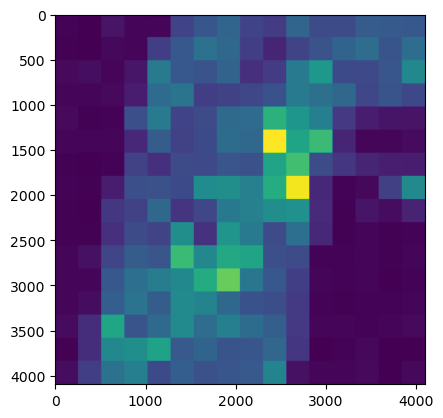

In [34]:
# region = Image.open(imgs_4k_list[-1])
# region = region.convert('RGB')   # converting MxNx4 (RGBA) --> MxNx3 (RGB format)
# x = eval_transforms()(region).unsqueeze(dim=0)
# print("Input Shape: ", x.shape)

# b256, a256, a4k = get_region_attention_scores(region, model256, model4k, scale=1)

# print(b256.shape)
# print(a256.shape)
# print(a4k.shape)



## 4096 x 4096 Demo (Concatenating + Saving Attention Maps)

In [10]:
# ### Lets automate this to save Attention maps of a bunch of images we wish to analyze
# path_test_imgs = '/mnt/hd1/ani/Liver_pathology_project/Prepared_datasets/Tile_size_4096x4096/Testing_sd_30/Test_set_NASH_id_156_ACR_id_262/NASH/'
# output_dir_parent = '/mnt/hd1/ani/Liver_pathology_project/Results/HIPT/4096x4096 images/Test_set_NASH_id_156/4k_concat/'

# test_imgs_list = (glob.glob(path_test_imgs + "*.png"))
# # len(test_imgs_list)

# for i in range(len(test_imgs_list)):
#     region = Image.open(test_imgs_list[i])
#     region = region.convert('RGB')   # converting MxNx4 (RGBA) --> MxNx3 (RGB format)    
#     output_dir = output_dir_parent + str(i+1)
#     os.makedirs(output_dir, exist_ok=True)
#     create_hierarchical_heatmaps_concat(region, model256, model4k, 
#                                    output_dir, fname=('region'+str(i+1)), 
#                                    scale=2, cmap=plt.get_cmap('coolwarm'), alpha=0.5,
#                                    )
#     del region

## Preparing dataset for slide-level classification 

#### Basically, we want to analyze all 4K tiles: for each slide, get learned feature vectors for each tile and take average to obtain slide-level representation. If "NASH", label=1, if "ACR", label=0

#### Creating "NASH", "ACR" image folders with patient sub-folders

In [11]:
# path_imgs = "/mnt/hd1/ani/Liver_pathology_project/Prepared_datasets/Tile_size_4096x4096/Patient_image_sets_sd_30/"

# labels = ["NASH", "ACR"]

# ### Let us dump 4096x4096 regions of "ACR" and "NASH" into 2 separate folders
# indiv_patient_imgs = [f.path for f in os.scandir(path_imgs) if f.is_dir()]
# unwanted_files = glob.glob(path_imgs + ".*ipynb_checkpoints")
# # indiv_patient_imgs

# # Create "NASH" and "ACR folders"
# path_folders = ("/mnt/hd1/ani/Liver_pathology_project/Prepared_datasets/Tile_size_4096x4096/")
# if (os.path.exists(path_folders + labels[1]) == False) & (os.path.exists(path_folders + labels[0]) == False):
#     os.mkdir(path_folders + labels[1])   # creates ACR folder
#     os.mkdir(path_folders + labels[0])   # creates NASH folder

# for i in range(len(indiv_patient_imgs)):
#     if indiv_patient_imgs[i] == unwanted_files[0]:
#         continue
    
#     if indiv_patient_imgs[i][-1] == 'A':
#         res_level_folder_a = [g.path for g in os.scandir(indiv_patient_imgs[i]) if g.is_dir()]
#         high_sig_folder_a = [h.path for h in os.scandir(res_level_folder_a[0]) if h.is_dir()][1]
        
#         # Get list of "png" files
#         img_list = (glob.glob(high_sig_folder_a + "/" + "*.png"))
        
#         # Copy files to "ACR" folder but put in specific patient sub-folder
#         path_acr_copy_dest = path_folders + labels[1] + "/" + os.path.splitext(os.path.basename(indiv_patient_imgs[i]))[0][:-1]
#         if os.path.exists(path_acr_copy_dest) == False:
#             os.mkdir(path_acr_copy_dest)
#             [shutil.copy(img_list[j], path_acr_copy_dest) for j in range(len(img_list))]
        
#     else:
#         res_level_folder_n = [g.path for g in os.scandir(indiv_patient_imgs[i]) if g.is_dir()]
#         high_sig_folder_n = [h.path for h in os.scandir(res_level_folder_n[0]) if h.is_dir()][1]
        
#         # Get list of "png" files
#         img_list = (glob.glob(high_sig_folder_n + "/" + "*.png"))
        
#         # Copy files to "NASH" folder but put in specific patient sub-folder
#         path_nash_copy_dest = path_folders + labels[0] + "/" + os.path.splitext(os.path.basename(indiv_patient_imgs[i]))[0][:-1]
#         if os.path.exists(path_nash_copy_dest) == False:
#             os.mkdir(path_nash_copy_dest)
#             [shutil.copy(img_list[l], path_nash_copy_dest) for l in range(len(img_list))]

### Create data matrix with (#patients, #features)

In [12]:
# # First lets get the patient sub-folders
# path_folders = ("/mnt/hd1/ani/Liver_pathology_project/Prepared_datasets/Tile_size_4096x4096/")
# labels = ["NASH", "ACR"]
# indiv_patient_folders_n = [p.path for p in os.scandir(path_folders + labels[0]) if p.is_dir()]
# indiv_patient_folders_a = [q.path for q in os.scandir(path_folders + labels[1]) if q.is_dir()]

# n_out_features = 192   # HIPT feature dimension

# feat_tensor_n, feat_tensor_a = torch.zeros(len(indiv_patient_folders_n), n_out_features), torch.zeros(len(indiv_patient_folders_a), n_out_features) 

# # NASH dataset
# for i in range(len(indiv_patient_folders_n)):
#     # Path of NASH images
#     imgs_list_nash = (glob.glob(indiv_patient_folders_n[i] + "/" + "*.png"))
    
#     # Initializing tensors to store extracted features
#     feat_tensor_nash = torch.zeros(len(imgs_list_nash), n_out_features)
    
#     for j in range(len(imgs_list_nash)):
#         region_nash = Image.open(imgs_list_nash[j])
#         region_nash = region_nash.convert('RGB')   # converting MxNx4 (RGBA) --> MxNx3 (RGB format)

#         # Forward propagate to get features
#         feat_tensor_nash[j,:] = hipt_forward_pass(region_nash, model256, model4k, scale=1, 
#                                                        device256=torch.device('cuda:0'), 
#                                                        device4k=torch.device('cuda:0'))
        
#     # Compute mean embedding as slide-level representation
#     feat_tensor_n[i, :] = torch.mean(feat_tensor_nash, dim=0)
                
        
# # ACR dataset      
# for u in range(len(indiv_patient_folders_a)):
#     # Path of ACR images
#     imgs_list_acr = (glob.glob(indiv_patient_folders_a[u] + "/" + "*.png"))
    
#     # Initializing tensors to store extracted features
#     feat_tensor_acr = torch.zeros(len(imgs_list_acr), n_out_features)
    
#     for v in range(len(imgs_list_acr)):
#         region_acr = Image.open(imgs_list_acr[v])
#         region_acr = region_acr.convert('RGB')   # converting MxNx4 (RGBA) --> MxNx3 (RGB format)

#         # Forward propagate to get features
#         feat_tensor_acr[v,:] = hipt_forward_pass(region_acr, model256, model4k, scale=1, 
#                                                        device256=torch.device('cuda:0'), 
#                                                        device4k=torch.device('cuda:0'))
        
#     # Compute mean embedding as slide-level representation
#     feat_tensor_a[u, :] = torch.mean(feat_tensor_acr, dim=0)

    
# # Lets also create tensors to store labels: "1" for Recurrent and "0" for Primary
# labels_n, labels_a = torch.ones(len(indiv_patient_folders_n),), torch.zeros(len(indiv_patient_folders_a),)

# # Checking tensor shapes
# print('Shape of NASH feature tensor: ', feat_tensor_n.shape)
# print('Shape of ACR feature tensor: ', feat_tensor_a.shape)
# print('Shape of NASH label tensor: ', labels_n.shape)
# print('Shape of ACR label tensor: ', labels_a.shape)

In [13]:
# # Converting all tensors to NumPy
# feat_tensor_n_np, feat_tensor_a_np, labels_n_np, labels_a_np = feat_tensor_n.numpy(), feat_tensor_a.numpy(), labels_n.numpy(), labels_a.numpy()

# # Keep equal no. of samples for both classes
# num_samples = np.minimum(len(indiv_patient_folders_n), len(indiv_patient_folders_a))

# # Randomly choose samples - this will be important for the class which has higher #examples
# inds = np.random.randint(num_samples, size=num_samples)

# feat_tensor_n_np_s, feat_tensor_a_np_s = feat_tensor_n_np[inds, :], feat_tensor_a_np[inds, :]
# labels_n_np_s, labels_a_np_s = labels_n_np[inds], labels_a_np[inds]

# # Stack class tensors
# features = np.vstack((feat_tensor_n_np_s, feat_tensor_a_np_s))
# labels = np.hstack((labels_n_np_s, labels_a_np_s))

# # print('Feature dimension: ', features.shape)
# # print('Label dimension: ', labels.shape)

# data = np.zeros((features.shape[0], features.shape[1]+1))
# data[:, :-1] = features
# data[:, -1] = labels

# print('Dataset dimension: ', data.shape)

# ### Saving data as ".csv"
# df_data = pd.DataFrame(data)
# df_data.to_csv("/mnt/hd1/ani/Liver_pathology_project/Data/HIPT_dataset_4kfeatures.csv")

## Train traditional ML models and evaluate performance: repeated sampling for robustness

In [2]:
# Read data from ".csv" file
dataset = pd.read_csv("/mnt/hd1/ani/Liver_pathology_project/Data/HIPT_dataset_4kfeatures.csv", index_col=0)
dataset = dataset.to_numpy()
X, y = dataset[:, :-1], dataset[:, -1]

out_file = "/mnt/hd1/ani/Liver_pathology_project/Results/HIPT/rf_hparams.txt"

num_iters = 10
f1_train, f1_test, auc_train, auc_test = [], [], [], []

f1_score_train, f1_score_test, auc_val_train, auc_val_test = np.zeros((num_iters,)), np.zeros((num_iters,)), np.zeros((num_iters,)), np.zeros((num_iters,))

for i in range(num_iters):
    # Split into train/test sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, shuffle=True)
    
    # Random Forest
    for n_estimators in (50, 100):
        for max_features in (2, 3):
            for min_samples_leaf in (1, 2):
                with open(out_file, "a") as f:
                    # f.write(f"MODEL: batch:{i+1}, n_estimators={n_estimators}, max_features={max_features}, min_sample_leaf={min_samples_leaf}\n")
                    # f.write("" +'\n')
                    # print(f"Training RF, batch:{i+1}, n_estimators={n_estimators}, max_features={max_features}, min_sample_leaf={min_samples_leaf}")
                    
                    model = RandomForestClassifier(n_estimators=n_estimators, 
                                                   max_features=max_features, 
                                                   min_samples_leaf=min_samples_leaf, 
                                                   random_state=1,
                                                   n_jobs=-1)
                    # Training
                    model.fit(X_train, y_train)
                    
                    # Get predictions on train + test set
                    y_preds_train = model.predict(X_train)
                    y_preds_test = model.predict(X_test)
                    
                    # Evaluate F-score on train + test set
                    f1_train.append(f1_score(y_train, y_preds_train, average='weighted'))
                    f1_test.append(f1_score(y_test, y_preds_test, average='weighted'))
                    
                    fpr_train, tpr_train, thresholds_train = roc_curve(y_train, y_preds_train, pos_label=1)
                    auc_train.append(auc(fpr_train, tpr_train))
                    fpr_test, tpr_test, thresholds_test = roc_curve(y_test, y_preds_test, pos_label=1)
                    auc_test.append(auc(fpr_test, tpr_test))
                    
                    # for each iteration, we want to store results only for the best set of hyperparams
                    if f1_train[-1] == np.max(f1_train):
                        n_est, max_feat, min_samp_leaf = n_estimators, max_features, min_samples_leaf
                        f1_train_f, f1_test_f, auc_train_f, auc_test_f = f1_train[-1], f1_test[-1], auc_train[-1], auc_test[-1]

    f1_train, f1_test = [], []
                                    
    print(f"Training RF, batch:{i+1}, n_estimators={n_est}, max_features={max_feat}, min_sample_leaf={min_samp_leaf}")
    print("Train F1-score: " + str(f1_train_f) + "\nTest F1-score: " + str(f1_test_f) + "\nTrain AUC: " + str(auc_train_f) + "\nTest AUC: " + str(auc_test_f)) 
    print('')
    
    # try:
    #     with open(out_file, "a") as f:
    #         f.write("Training F1-score: " + str(f1_train_f)+'\n')
    #         f.write("Testing F1-score: " + str(f1_test_f)+'\n')
    # except ValueError:
    #     with open(out_file, "a") as f:
    #         f.write("NaN\n")
            
    f1_score_train[i], f1_score_test[i], auc_val_train[i], auc_val_test[i] = f1_train_f, f1_test_f, auc_train_f, auc_test_f

print("Final train F1-score mean: ", np.mean(f1_score_train))
print("Final train F1-score std: ", np.std(f1_score_train))
print("Final test F1-score mean: ", np.mean(f1_score_test))
print("Final test F1-score std: ", np.std(f1_score_test))
print("Final train AUC mean: ", np.mean(auc_val_train))
print("Final train AUC std: ", np.std(auc_val_train))
print("Final test AUC mean: ", np.mean(auc_val_test))
print("Final test AUC std: ", np.std(auc_val_test))

Training RF, batch:1, n_estimators=100, max_features=3, min_sample_leaf=2
Train F1-score: 1.0
Test F1-score: 1.0
Train AUC: 1.0
Test AUC: 1.0

Training RF, batch:2, n_estimators=100, max_features=3, min_sample_leaf=2
Train F1-score: 1.0
Test F1-score: 0.876984126984127
Train AUC: 1.0
Test AUC: 0.9

Training RF, batch:3, n_estimators=100, max_features=3, min_sample_leaf=2
Train F1-score: 1.0
Test F1-score: 1.0
Train AUC: 1.0
Test AUC: 1.0

Training RF, batch:4, n_estimators=100, max_features=3, min_sample_leaf=2
Train F1-score: 1.0
Test F1-score: 1.0
Train AUC: 1.0
Test AUC: 1.0

Training RF, batch:5, n_estimators=100, max_features=3, min_sample_leaf=2
Train F1-score: 1.0
Test F1-score: 0.4246031746031746
Train AUC: 1.0
Test AUC: 0.6428571428571428

Training RF, batch:6, n_estimators=100, max_features=3, min_sample_leaf=2
Train F1-score: 1.0
Test F1-score: 0.873015873015873
Train AUC: 1.0
Test AUC: 0.875

Training RF, batch:7, n_estimators=100, max_features=3, min_sample_leaf=2
Train F1

In [15]:
### Confusion Matrix

classes = ("ACR", "NASH")

cm = confusion_matrix(y_test, y_preds_test)
df_cm = pd.DataFrame(cm, index = [i for i in classes], columns = [i for i in classes])

# Plotting
plt.figure(figsize = (5, 4))
sns.heatmap(df_cm, annot=True, fmt=".0f", cbar=False);
# plt.savefig(f"/mnt/hd1/ani/Liver_pathology_project/Results/HIPT/ConfMat_test_frac_0p7.png")